comparison of DE to this method

In [1]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import scanpy as sc

In [3]:

with open('../../data/gene_lists/mouse_markers.txt') as f:
    markers = list(f)
markers = [x for x in markers if not x.startswith('#') and ':' in x]
markers = dict(map(lambda x: x.strip().split(':'), markers)) #dict marker:role


#add senmayo
senmayo = pd.read_csv('../../data/gene_lists/senMayo.csv')['Gene(human)'].values.tolist() #FIX MOUSE
senmayo = [x[0] + x[1:].lower() for x in senmayo]
senmayo = [x for x in senmayo if x not in list(markers)]
senmayo = {x:'senmayo' for x in senmayo}
markers = markers | senmayo

In [4]:
bg = sc.read_h5ad('../../data/tms/tms-scVI-raw-data.h5ad').var_names

In [5]:
len(bg)

20116

In [6]:
de = pd.read_csv('../../data/gene_lists/elife-62293-supp2-v2-1_aging_genes.csv', index_col=0).T

In [8]:
sp = pd.concat(
(pd.read_csv('mouse_gene_stats_fin.csv', index_col=0).reset_index(drop = True),
pd.read_csv('mouse_gene_stats_addition.csv', index_col=0).reset_index(drop = True)))

The highest enrichment of known senescence markers (one of the best metrics we have that this is working) is found at the union of newly added genes (ones with fdr < 0.05) and genes that were filtered previously AND are still expected to be found at a rate less than 1% by chance. The latter is likely becasue senescence programs that occur in a smaller number of cells are considered "less significant" than ones that happen in more cells, e.g., 2% vs 5%. There is another filtering method later on that uses fdr correction on all comparisons. Regardless, the majority of OrigiFilt == True were also BH < 0.05

In [9]:
sp = sp[(sp.BH < 0.05) | ((sp.OrigFilt) & (sp.p < 0.01))]

In [10]:
out = []

a = set(markers)
for i in de.index:
    b = set(de.loc[i][de.loc[i] == 1].index)
    n = a.intersection(b)
    r = stats.hypergeom.sf(len(n) - 1, len(bg), len(a), len(b))
    out.append([i,r])

In [11]:
de_res = pd.DataFrame(out, columns = ['cell', 'p']).sort_values('p').reset_index(drop = True)

In [12]:
de_res['fdr'] = de_res.p * len(de_res)
de_res['fdr'] = de_res['fdr'].clip(upper=1)

In [13]:
de_res[de_res.fdr < 0.05]

,cell,p,fdr
0,GAT.mesenchymal stem cell of adipose,1.868490e-08,0.000001
1,Bladder.bladder cell,7.490523e-08,0.000006
2,Liver.endothelial cell of hepatic sinusoid,4.981055e-07,0.000038
3,Heart.fibroblast of cardiac tissue,9.454257e-07,0.000072
4,SCAT.myeloid cell,1.050035e-06,0.000080
5,MAT.mesenchymal stem cell of adipose,2.334265e-06,0.000177
6,Limb_Muscle.mesenchymal stem cell,3.508881e-06,0.000267
7,Mammary_Gland.basal cell,6.478482e-05,0.004924
8,SCAT.mesenchymal stem cell of adipose,9.014234e-05,0.006851
9,GAT.myeloid cell,1.789294e-04,0.013599


In [14]:
len(de_res[de_res.fdr < 0.05])/len(de_res)

0.19736842105263158

In [15]:
out = []

a = set(markers)
for cell in sp.tissue_cell.unique():
    _ = sp[sp.tissue_cell == cell]
    b = set(_.gene)
    n = a.intersection(b)
    r = stats.hypergeom.sf(len(n) - 1, len(bg), len(a), len(b))
    out.append([cell,r])

In [16]:
sp_res = pd.DataFrame(out, columns = ['cell', 'p']).sort_values('p').reset_index(drop = True)
sp_res['fdr'] = sp_res.p * len(sp_res)
sp_res['fdr'] = sp_res['fdr'].clip(upper=1)

In [17]:
sp_res[sp_res.fdr < 0.05]

,cell,p,fdr
0,Heart_and_Aorta.endocardial cell,5.575845e-12,3.903091e-10
1,Lung.fibroblast,1.106812e-07,7.747685e-06
2,Tongue.keratinocyte,1.292867e-07,9.050066e-06
3,Trachea.fibroblast,1.585399e-07,1.109780e-05
4,Tongue.basal cell,1.648250e-07,1.153775e-05
5,Bladder.bladder urothelial cell,2.440882e-07,1.708618e-05
6,Heart_and_Aorta.endothelial cell,1.579100e-06,1.105370e-04
7,Heart_and_Aorta.fibroblast,1.647567e-06,1.153297e-04
8,Mammary_Gland.luminal epithelial cell of mamma...,4.022495e-06,2.815746e-04
9,Lung.adventitial cell,4.835666e-06,3.384966e-04


In [18]:
len(sp_res[sp_res.fdr < 0.05])/len(sp_res)

0.2714285714285714

In [19]:
sp_res['Model'] = 'senePy'
de_res['Model'] = 'DE'

In [20]:
df = pd.concat((sp_res, de_res))

In [21]:
df

,cell,p,fdr,Model
0,Heart_and_Aorta.endocardial cell,5.575845e-12,3.903091e-10,senePy
1,Lung.fibroblast,1.106812e-07,7.747685e-06,senePy
2,Tongue.keratinocyte,1.292867e-07,9.050066e-06,senePy
3,Trachea.fibroblast,1.585399e-07,1.109780e-05,senePy
4,Tongue.basal cell,1.648250e-07,1.153775e-05,senePy
...,...,...,...,...
71,Brain_Non-Myeloid.neuron,9.999994e-01,1.000000e+00,DE
72,MAT.macrophage,1.000000e+00,1.000000e+00,DE
73,MAT.B cell,1.000000e+00,1.000000e+00,DE
74,Kidney.kidney collecting duct epithelial cell,1.000000e+00,1.000000e+00,DE


In [22]:
df['nlog10'] = -np.log10(df.fdr)

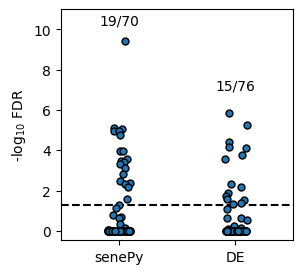

In [24]:
plt.figure(figsize=(3,3))

ax = sns.stripplot(data = df, x = 'Model', y = 'nlog10', edgecolor='k', linewidth=1)

plt.axhline(-np.log10(0.05), zorder = 0, c = 'k', ls = '--')


plt.text(s = f'{len(sp_res[sp_res.fdr < 0.05])}/{len(sp_res)}', x = 0, y = 10.25, ha = 'center')
plt.text(s = f'{len(de_res[de_res.fdr < 0.05])}/{len(de_res)}', x = 1, y = 7, ha = 'center')

plt.ylim(top = 11)

plt.ylabel(r'-log$_{10}$ FDR')
plt.xlabel('')


plt.savefig('../figures/R1_R1_MP3.png', dpi = 600, transparent = True, bbox_inches = 'tight')
plt.savefig('../figures/R1_R1_MP3.svg', transparent = True, bbox_inches = 'tight')

plt.show()

In [ ]:
#how many have well known sen genes

In [ ]:
#there is non with Cdkn2a in DE
[x for x in de.columns if x.startswith('Cdkn')]

In [183]:
#there are 20 in the senePy data
len(sp[sp.gene == 'Cdkn2a'])

20